# LSTM Regression for Cherry Blossom Bloom Day

This notebook trains an LSTM neural network to predict cherry blossom bloom day.
It mirrors the OLS, SARIMAX, LightGBM, and Random Forest notebooks: same data splits, metrics, and plotting style.


# Plan and assumptions

- Use the same numeric predictors as in the other notebooks.
- Use years 1921–2015 as the pool for training/validation and perform a sequential 80/20 split to preserve temporal order.
- Reserve 2016–2025 as the test set and report performance on that set.
- Metrics: RMSE, MAE, and WMAPE (sum(|error|) / sum(|actual|)).
- We'll use Keras (TensorFlow backend) for the LSTM model, with early stopping.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

sns.set_theme(style='whitegrid')


# 1) Load data

In [4]:
DATA_PATH = '../data/cherry_blossom_data.csv'
df = pd.read_csv(DATA_PATH)
print('Loaded rows:', len(df))
# df.head()  # Uncomment to inspect


Loaded rows: 107


# 2) Prepare features and target

In [5]:
numeric_cols = ['days_dec_ge_45','days_jan_ge_45','days_feb_ge_45','prec_winter',
                'mean_temp_winter','surface_temp_chg','climate_incidents']
for c in numeric_cols + ['bloom_day','year']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

df = df.dropna(subset=['year','bloom_day'] + numeric_cols).reset_index(drop=True)

FEATURES = numeric_cols
TARGET = 'bloom_day'


# 3) Create train / validation / test splits (sequential)

In [6]:
train_val_df = df[(df['year'] >= 1921) & (df['year'] <= 2015)].sort_values('year').reset_index(drop=True)
test_df = df[(df['year'] >= 2016) & (df['year'] <= 2025)].sort_values('year').reset_index(drop=True)

print(f'Train/Val rows: {len(train_val_df)}, Test rows: {len(test_df)}')

n = len(train_val_df)
if n == 0:
    raise ValueError('No data in 1921-2015 range to train/validate on.')
train_n = int(np.floor(n * 0.8))
train_df = train_val_df.iloc[:train_n].reset_index(drop=True)
val_df = train_val_df.iloc[train_n:].reset_index(drop=True)

print(f'Train rows: {len(train_df)}, Val rows: {len(val_df)}')

X_train = train_df[FEATURES].values
y_train = train_df[TARGET].values
X_val = val_df[FEATURES].values
y_val = val_df[TARGET].values
X_test = test_df[FEATURES].values
y_test = test_df[TARGET].values if len(test_df) > 0 else None

full_years = df['year']
full_actuals = df[TARGET]


Train/Val rows: 97, Test rows: 10
Train rows: 77, Val rows: 20


# 4) Scale features (fit on train, transform all)

In [7]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test) if len(test_df) > 0 else None
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten() if y_test is not None else None


# 5) Reshape for LSTM: (samples, timesteps, features)
We'll use 1 timestep (no lag features) for direct regression, matching other models

In [8]:
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_lstm = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1])) if X_test_scaled is not None else None


# 6) Build and train LSTM model (with early stopping)

In [9]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.Sequential([
    layers.LSTM(32, input_shape=(1, X_train_lstm.shape[2]), activation='tanh', return_sequences=False),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse')

es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
history = model.fit(
    X_train_lstm, y_train_scaled,
    validation_data=(X_val_lstm, y_val_scaled),
    epochs=500,
    batch_size=8,
    callbacks=[es],
    verbose=2
)


Epoch 1/500


/Users/ecilteodoro/miniconda3/envs/cherry-blossom-env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 - 1s - 62ms/step - loss: 1.0243 - val_loss: 0.8591
Epoch 2/500
10/10 - 0s - 3ms/step - loss: 0.9117 - val_loss: 0.7509
Epoch 3/500
10/10 - 0s - 3ms/step - loss: 0.8682 - val_loss: 0.7817
Epoch 4/500
10/10 - 0s - 3ms/step - loss: 0.8123 - val_loss: 0.8757
Epoch 5/500
10/10 - 0s - 3ms/step - loss: 0.7613 - val_loss: 1.0287
Epoch 6/500
10/10 - 0s - 3ms/step - loss: 0.7088 - val_loss: 1.1111
Epoch 7/500
10/10 - 0s - 3ms/step - loss: 0.6578 - val_loss: 1.1620
Epoch 8/500
10/10 - 0s - 3ms/step - loss: 0.6211 - val_loss: 1.1553
Epoch 9/500
10/10 - 0s - 3ms/step - loss: 0.5728 - val_loss: 1.1539
Epoch 10/500
10/10 - 0s - 3ms/step - loss: 0.5425 - val_loss: 1.1913
Epoch 11/500
10/10 - 0s - 3ms/step - loss: 0.4890 - val_loss: 1.1546
Epoch 12/500
10/10 - 0s - 3ms/step - loss: 0.4467 - val_loss: 1.1712
Epoch 13/500
10/10 - 0s - 3ms/step - loss: 0.4031 - val_loss: 1.0919
Epoch 14/500
10/10 - 0s - 3ms/step - loss: 0.3570 - val_loss: 1.1363
Epoch 15/500
10/10 - 0s - 3ms/step - loss: 0.3209 - va

# 7) Validation diagnostics

In [10]:
val_pred_scaled = model.predict(X_val_lstm).flatten()
val_pred = scaler_y.inverse_transform(val_pred_scaled.reshape(-1, 1)).flatten()
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
val_mae = mean_absolute_error(y_val, val_pred)
val_wmape = np.sum(np.abs(y_val - val_pred)) / np.sum(np.abs(y_val))

print('Validation RMSE: {:.3f}'.format(val_rmse))
print('Validation MAE: {:.3f}'.format(val_mae))
print('Validation WMAPE: {:.3%}'.format(val_wmape))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Validation RMSE: 6.174
Validation MAE: 4.766
Validation WMAPE: 5.232%


# 8) Evaluate on test set (2016-2025)

In [11]:
y_pred_test = None
if len(test_df) == 0:
    print('No test data available for 2016-2025 range.')
else:
    y_pred_test_scaled = model.predict(X_test_lstm).flatten()
    y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_wmape = np.sum(np.abs(y_test - y_pred_test)) / np.sum(np.abs(y_test))

    print('\nTest set performance (2016-2025)')
    print('Rows:', len(test_df))
    print('RMSE: {:.3f}'.format(test_rmse))
    print('MAE: {:.3f}'.format(test_mae))
    print('WMAPE: {:.3%}'.format(test_wmape))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

Test set performance (2016-2025)
Rows: 10
RMSE: 7.999
MAE: 6.947
WMAPE: 8.192%


# 9) Plot actuals (since 1921) and forecasts (2016-2025) with a dashed vertical line at 2016

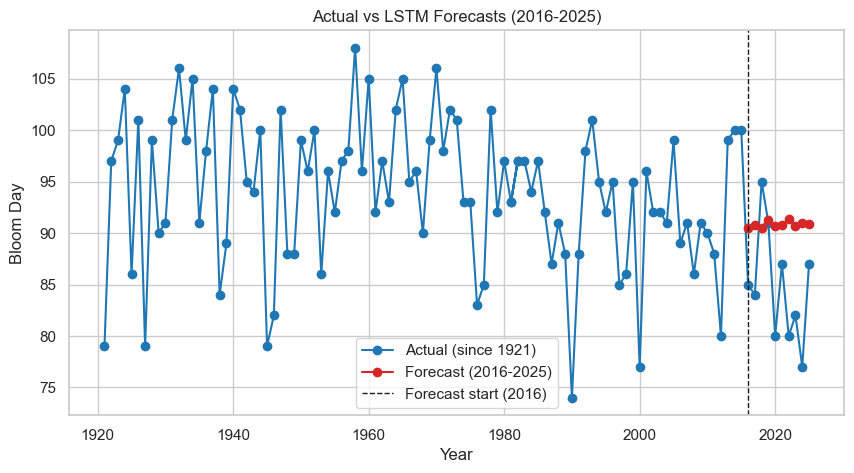

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(full_years, full_actuals.values, marker='o', color='tab:blue', label='Actual (since 1921)')

if len(test_df) > 0 and y_pred_test is not None:
    plt.plot(test_df['year'], y_pred_test, marker='o', color='tab:red', label='Forecast (2016-2025)')
    plt.axvline(2016, color='k', linestyle='--', linewidth=1, label='Forecast start (2016)')

plt.xlabel('Year')
plt.ylabel('Bloom Day')
plt.title('Actual vs LSTM Forecasts (2016-2025)')
plt.legend()
plt.grid(True)
plt.show()


# 10) Notes and next steps

- This LSTM model provides a deep learning approach for time series regression. If you'd like, I can:
  - Add lag features or use a rolling window for true sequence modeling.
  - Add hyperparameter tuning (KerasTuner or Optuna).
  - Add SHAP explanations for interpretability (DeepSHAP).
  - Use time-series CV folds for more robust validation.

- To install TensorFlow: pip install tensorflow
- For reproducibility, set random seeds as above.
